In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
os.chdir("d:/Projet/cse")

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import sys
sys.path.append("../")
from cse.src.data_preprocessing.missing_values.drop_mv_imputer import DropMvImputer
from cse.src.data_preprocessing.scaler.id_scaler import IdScaler
from cse.src.data_preprocessing.scaler.id_encoder import IdEncoder
import numpy as np
from sklearn.model_selection import train_test_split

In [33]:
data = pd.read_csv("data/raw/cs-training.csv").iloc[:, 1:]
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

In [34]:
X.shape, y.shape

((150000, 10), (150000,))

In [6]:
# Séparation en train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape

((120000, 10), (30000, 10))

Revenu = 0 --> NA et Revenu > 
Revenu en catégorie --> 0 = pas de revenu

# Traitement des individus avec un revenu 

In [35]:
from cse.src.data_viz.plot import Plot

In [47]:
X_train.MonthlyIncome.describe()

count    9.632500e+04
mean     6.651507e+03
std      1.454118e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.390000e+03
75%      8.238000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

In [57]:
X_train.loc[(0 < X_train.MonthlyIncome) & (X_train.MonthlyIncome <= 15000)].shape

(90761, 10)

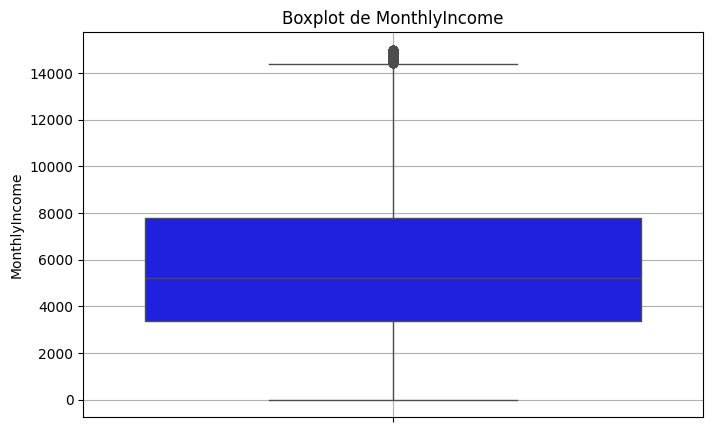

In [55]:
Plot(X_train.loc[(0 < X_train.MonthlyIncome) & (X_train.MonthlyIncome < 15000)]).boxplot("MonthlyIncome")

d:\Projet\cse\..\cse\src\data_viz\plot.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=self.data, x=var_cat, y=var_quant, palette="Set2")


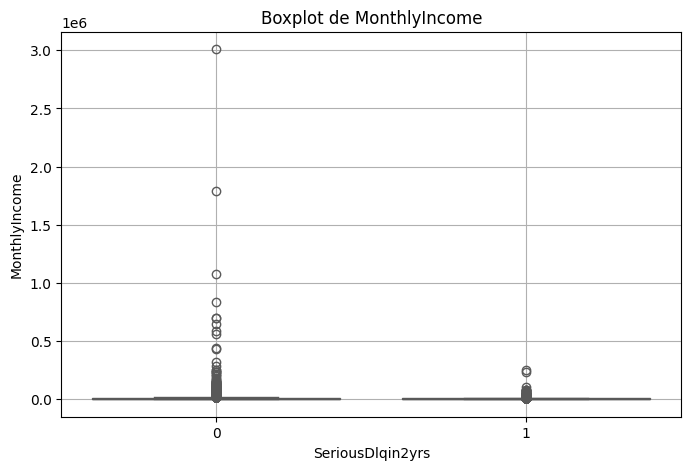

In [ ]:
Plot(pd.concat([y_train, X_train], axis=1)).boxplot("MonthlyIncome", "SeriousDlqin2yrs")

In [58]:
X_train.loc[(0 == X_train.MonthlyIncome) | (X_train.MonthlyIncome >= 15000), "MonthlyIncome"] = np.nan

In [59]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
# Identifier les colonnes numériques et catégorielles automatiquement
num_features = X_train.select_dtypes(include=["int64", "float64", "bool"]).columns
cat_features = X_train.select_dtypes(include=["object", "category"]).columns

# Création du préprocesseur
scaler1 = ColumnTransformer([
    ("num", StandardScaler(), num_features),    # Normalisation des variables numériques
    ("cat", IdEncoder(), cat_features)  # Encodage des variables catégorielles
])


In [60]:
X_train[["MonthlyIncome"]]

,MonthlyIncome
57836,NaN
132895,3800.0
27981,3716.0
37852,NaN
103813,3000.0
...,...
18048,7695.0
3895,8583.0
109980,NaN
74354,1535.0


L'idée sera de faire 2 modèles : 1 pour ceux qui ont un revenu inclu dans ]0, 15000[ et un autre pour ceux qui on un revenu nul ou >= 15000 ou encore non déclaré

# Premier draft

In [61]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ("imputer", DropMvImputer()),
    ("scaler", scaler),  # Normalisation des données
    # ("classifier", RandomForestClassifier(n_estimators=100, random_state=42)),  # Modèle de classification
    ("classifier", LogisticRegression())  # Modèle de régression logistique
])
pipeline

Pipeline(steps=[('imputer', DropMvImputer()),
                ('scaler',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')),
                                                 ('cat', IdEncoder(),
                                                  Index([], dtype='object'))])),
                ('classifier', LogisticRegression())])

In [62]:
try:
    pipeline.fit(X_train, y_train)
except:
    import pandas as pd
    df = pd.read_csv('d:/Projet/cse/data/temp/liste.txt', header=None)
    liste = df[0].tolist()
    y_train = y_train.loc[~y_train.index.isin(liste)]
    pipeline.fit(X_train, y_train)

!!! Il vous faut enlever des lignes de la cible 'y'
en raison de la suppression des lignes ayant des valeurs manquantes dans X.
un fichier temporaire sera créé ici : d:/Projet/cse/data/temp/liste.txt
Ce fichier contient les index des lignes à supprimer dans X
Exécuter le code suivant pour transformer votre y :

                import pandas as pd
                df = pd.read_csv('d:/Projet/cse/data/temp/liste.txt', header=None)
                liste = df[0].tolist()
                y = y.loc[~y.index.isin(liste)]
                


In [63]:
pipeline

Pipeline(steps=[('imputer', DropMvImputer()),
                ('scaler',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')),
                                                 ('cat', IdEncoder(),
                                                  Index([], dtype='object'))])),
                ('classifier', LogisticRegression())])

In [64]:
row_is_with_mv = X_test.isnull().any(axis=1)
X_test_cor = X_test[~row_is_with_mv]
y_test_cor = y_test[~row_is_with_mv]

In [65]:
y_test_predict = pipeline.predict(X_test_cor)

🔹 Accuracy  : 0.9314
🔹 Precision : 0.5586
🔹 Recall    : 0.0375
🔹 F1-score  : 0.0702



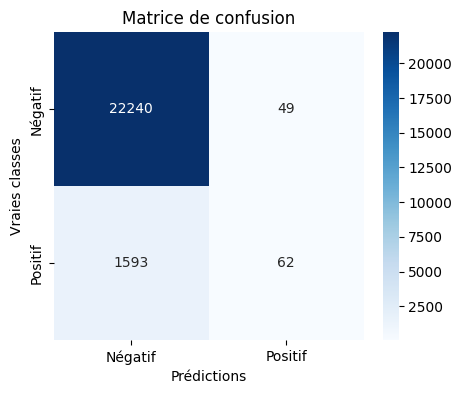

{'accuracy': 0.9314233210825259,
 'precision': np.float64(0.5585585585585585),
 'recall': np.float64(0.03746223564954683),
 'f1_score': np.float64(0.07021517553793885),
 'classification_report': {'0': {'precision': 0.9331599043343264,
   'recall': 0.9978016061734488,
   'f1-score': 0.964398768483587,
   'support': 22289.0},
  '1': {'precision': 0.5585585585585585,
   'recall': 0.03746223564954683,
   'f1-score': 0.07021517553793885,
   'support': 1655.0},
  'accuracy': 0.9314233210825259,
  'macro avg': {'precision': 0.7458592314464425,
   'recall': 0.5176319209114978,
   'f1-score': 0.5173069720107629,
   'support': 23944.0},
  'weighted avg': {'precision': 0.9072676044989232,
   'recall': 0.9314233210825259,
   'f1-score': 0.9025931450988122,
   'support': 23944.0}}}

In [66]:
from cse.src.evaluation.pipeline_evaluator import PipelineEvaluator
eval = PipelineEvaluator(pipeline=pipeline).fit()
eval.predict(X_test_cor, y_test_cor)

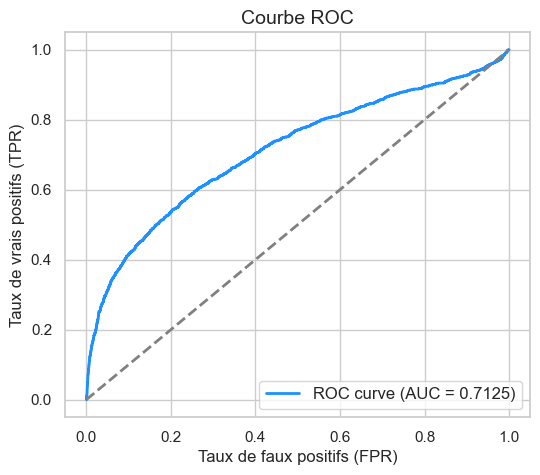

np.float64(0.7124942207277404)

In [67]:
eval.plot_roc_curve(X_test_cor, y_test_cor)

# Draft 2

🔹 Accuracy  : 0.9341
🔹 Precision : 0.5736
🔹 Recall    : 0.1813
🔹 F1-score  : 0.2755



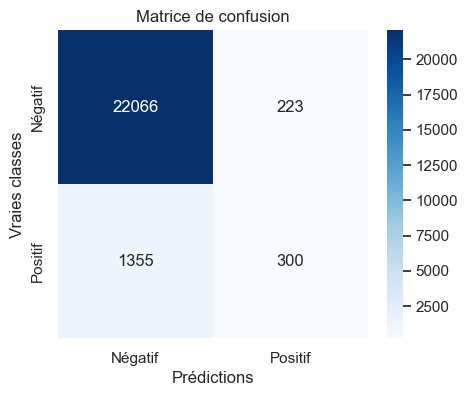

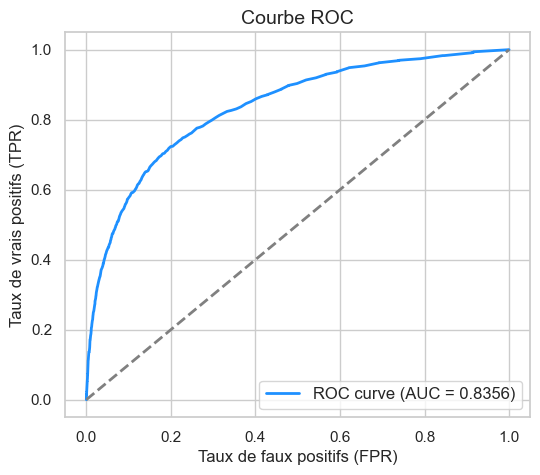

np.float64(0.8355804734265978)

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ("imputer", DropMvImputer()),
    ("scaler", scaler),  # Normalisation des données
    ("classifier", RandomForestClassifier(n_estimators=500, random_state=42))  # Modèle de régression logistique
])

try:
    pipeline.fit(X_train, y_train)
except:
    import pandas as pd
    df = pd.read_csv('d:/Projet/cse/data/temp/liste.txt', header=None)
    liste = df[0].tolist()
    y_train = y_train.loc[~y_train.index.isin(liste)]
    pipeline.fit(X_train, y_train)

row_is_with_mv = X_test.isnull().any(axis=1)
X_test_cor = X_test[~row_is_with_mv]
y_test_cor = y_test[~row_is_with_mv]

y_test_predict = pipeline.predict(X_test_cor)

from cse.src.evaluation.pipeline_evaluator import PipelineEvaluator
eval = PipelineEvaluator(pipeline=pipeline).fit()
eval.predict(X_test_cor, y_test_cor)

eval.plot_roc_curve(X_test_cor, y_test_cor)

# Draft 3

🔹 Accuracy  : 0.9339
🔹 Precision : 0.6424
🔹 Recall    : 0.1958
🔹 F1-score  : 0.3002



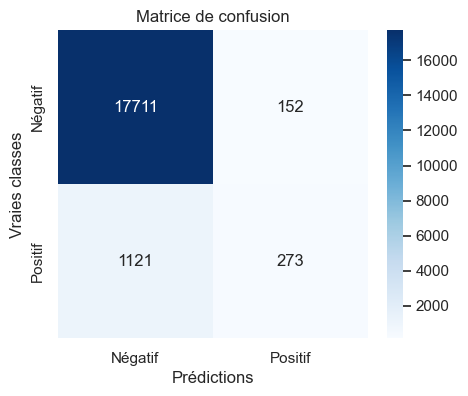

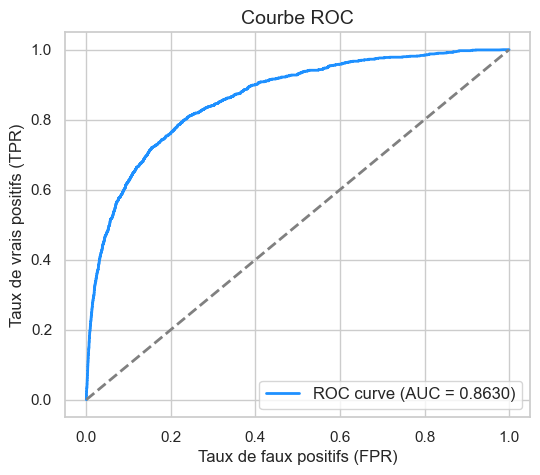

np.float64(0.8629881737384111)

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline([
    ("imputer", DropMvImputer()),
    ("scaler", scaler),  # Normalisation des données
    ("classifier", GradientBoostingClassifier(
        n_estimators=100, random_state=42, learning_rate=0.1))  # Modèle de régression logistique
])

try:
    pipeline.fit(X_train, y_train)
except:
    import pandas as pd
    df = pd.read_csv('d:/Projet/cse/data/temp/liste.txt', header=None)
    liste = df[0].tolist()
    y_train = y_train.loc[~y_train.index.isin(liste)]
    pipeline.fit(X_train, y_train)

row_is_with_mv = X_val.isnull().any(axis=1)
X_val_cor = X_val[~row_is_with_mv]
y_val_cor = y_val[~row_is_with_mv]

y_val_predict = pipeline.predict(X_val_cor)

from cse.src.evaluation.pipeline_evaluator import PipelineEvaluator
eval = PipelineEvaluator(pipeline=pipeline).fit()
eval.predict(X_val_cor, y_val_cor)

eval.plot_roc_curve(X_val_cor, y_val_cor)

# Draft 4

🔹 Accuracy  : 0.8899
🔹 Precision : 0.2635
🔹 Recall    : 0.2905
🔹 F1-score  : 0.2764



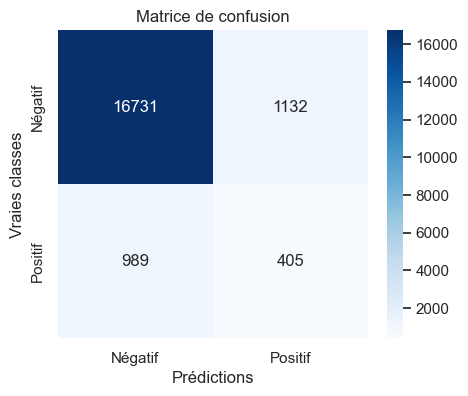

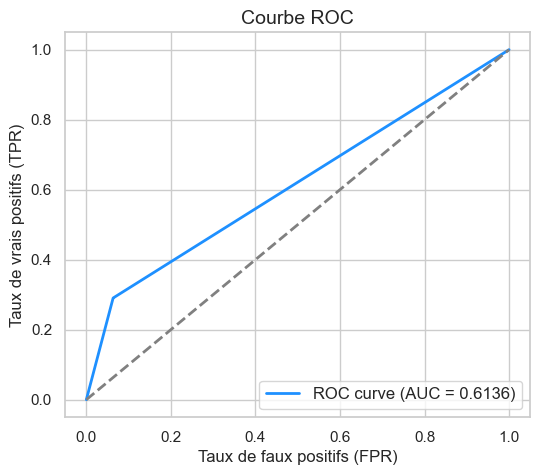

np.float64(0.6135599574989332)

In [35]:
from sklearn.tree import DecisionTreeClassifier

pipeline = Pipeline([
    ("imputer", DropMvImputer()),
    ("scaler", scaler),  # Normalisation des données
    ("classifier", DecisionTreeClassifier(random_state=42))  # Modèle de régression logistique
])

try:
    pipeline.fit(X_train, y_train)
except:
    import pandas as pd
    df = pd.read_csv('d:/Projet/cse/data/temp/liste.txt', header=None)
    liste = df[0].tolist()
    y_train = y_train.loc[~y_train.index.isin(liste)]
    pipeline.fit(X_train, y_train)

row_is_with_mv = X_val.isnull().any(axis=1)
X_val_cor = X_val[~row_is_with_mv]
y_val_cor = y_val[~row_is_with_mv]

y_val_predict = pipeline.predict(X_val_cor)

from cse.src.evaluation.pipeline_evaluator import PipelineEvaluator
eval = PipelineEvaluator(pipeline=pipeline).fit()
eval.predict(X_val_cor, y_val_cor)

eval.plot_roc_curve(X_val_cor, y_val_cor)

# Cross validate

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Identifier les colonnes numériques et catégorielles automatiquement
num_features = X_train.select_dtypes(include=["int64", "float64", "bool"]).columns
cat_features = X_train.select_dtypes(include=["object", "category"]).columns

# Création du préprocesseur
scaler = ColumnTransformer([
    ("num", StandardScaler(), num_features),    # Normalisation des variables numériques
    ("cat", IdEncoder(), cat_features)  # Encodage des variables catégorielles
])
scaler

pipeline = Pipeline([
    ("imputer", DropMvImputer()),
    ("scaler", scaler),  # Normalisation des données
    ("classifier", RandomForestClassifier(random_state=42))  # Modèle de régression logistique
])

In [ ]:
# Grille de paramètres à tester
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [ ]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1-score', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Meilleurs paramètres :", grid_search.best_params_)
y_pred = grid_search.best_estimator_.predict(X_test)
print("\nRapport de classification :\n", classification_report(y_test, y_pred))